<a href="https://colab.research.google.com/github/venugopals002/Venus/blob/main/BOPP_tape_analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load cleaned dataset
df = pd.read_excel('/content/BOPP tapes data 2024.xlsx')  # File must have Width_mm, Length_m, Thickness_microns, Units_Sold_2024, Country, SKU

In [3]:
# Feature engineering: Create dimension composite key
df['Dimension_Key'] = df['Width_mm'].astype(str) + 'mm × ' + \
                      df['Length_m'].round(1).astype(str) + 'm × ' + \
                      df['Thickness_microns'].astype(str) + 'μ'

In [4]:
# Step 1: Pareto Analysis
def pareto_analysis(df, country):
    country_df = df[df['Country'] == country]
    sorted_df = country_df.sort_values(by='Units_Sold_2024', ascending=False)
    sorted_df['Cumulative'] = sorted_df['Units_Sold_2024'].cumsum()
    sorted_df['Cumulative_Percent'] = 100 * sorted_df['Cumulative'] / sorted_df['Units_Sold_2024'].sum()
    top_20_percent = sorted_df[sorted_df['Cumulative_Percent'] <= 80]
    low_20_percent = sorted_df.tail(int(0.2 * len(sorted_df)))
    return top_20_percent, low_20_percent

In [5]:
ksa_top, ksa_low = pareto_analysis(df, 'KSA')
bhr_top, bhr_low = pareto_analysis(df, 'Bahrain')

In [6]:
# Step 2: Clustering SKU Dimensions (for Rationalization Candidates)
X = df[['Width_mm', 'Length_m', 'Thickness_microns']].copy()

# Normalize for clustering
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# DBSCAN for finding "similar" SKUs (parameter tuning done based on tolerance of ±5mm, ±10%, ±5μm)
db = DBSCAN(eps=1.2, min_samples=2).fit(X_scaled)
df['Cluster'] = db.labels_

In [10]:
# Step 3: Summary: Show clusters with high total volume and SKU count
cluster_summary = df.groupby('Cluster').agg({
    'SKU': 'count',
    'Units_Sold_2024': 'sum'
}).rename(columns={'SKU': 'SKU_Count', 'Units_Sold_2024': 'Total_Units_Sold'}).sort_values(by='Total_Units_Sold', ascending=False)

In [11]:
# Step 4: Recommendations – flag slow movers and mergeable clusters
df['Flag'] = np.where(df['SKU'].isin(ksa_low['SKU']) | df['SKU'].isin(bhr_low['SKU']), 'Slow Mover', '')
df['Cluster_Flag'] = df['Cluster'].apply(lambda x: 'Candidate for Merge' if x != -1 else '')

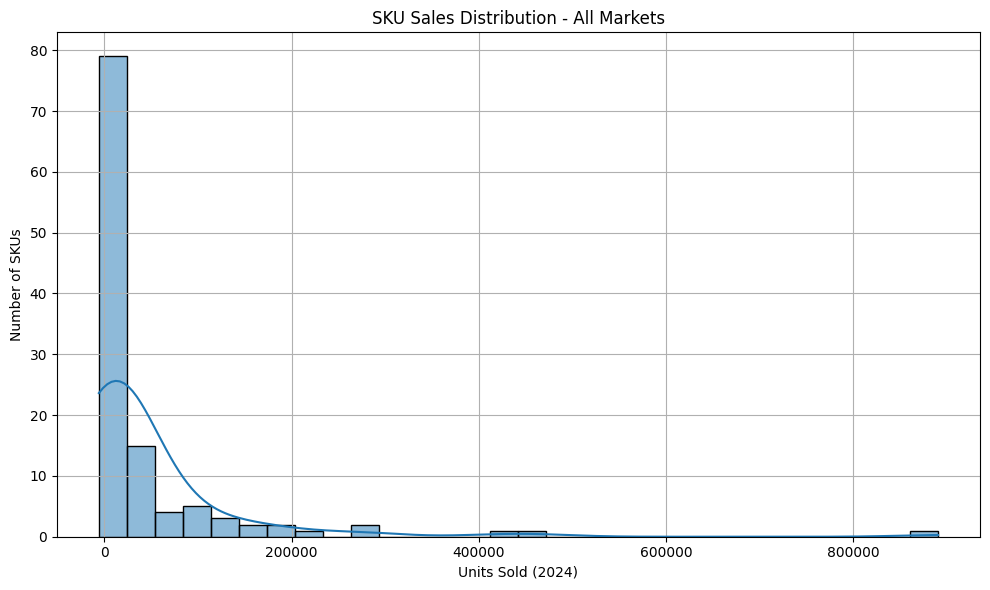

In [12]:
# Step 5: Visualization – SKU Sales Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['Units_Sold_2024'], bins=30, kde=True)
plt.title('SKU Sales Distribution - All Markets')
plt.xlabel('Units Sold (2024)')
plt.ylabel('Number of SKUs')
plt.grid(True)
plt.tight_layout()
plt.show()

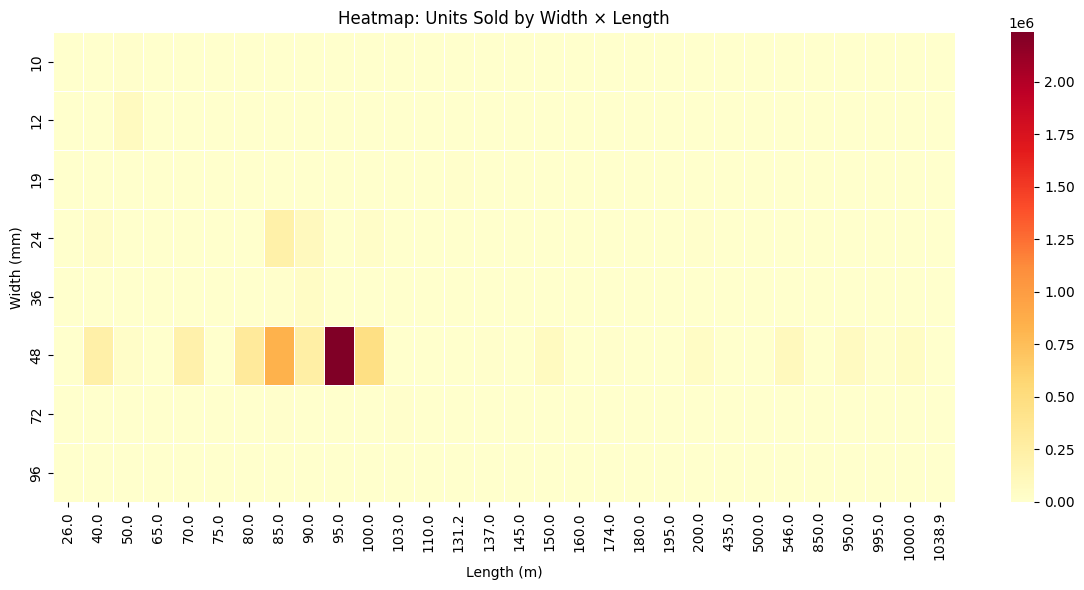

In [13]:
# Step 6: Heatmap – Width vs Length with Units Sold
pivot = df.pivot_table(index='Width_mm', columns='Length_m', values='Units_Sold_2024', aggfunc='sum', fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlOrRd', linewidths=0.5)
plt.title('Heatmap: Units Sold by Width × Length')
plt.xlabel('Length (m)')
plt.ylabel('Width (mm)')
plt.tight_layout()
plt.show()

In [14]:
# Step 7: Export Recommendations
df.to_csv('SKU_Rationalization_Results.csv', index=False)
cluster_summary.to_csv('Cluster_Summary.csv')